In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:

class neural_net:
  def __init__(self,input , y ,nodes_per_layer,activations , print_weights=False):
#     x shape is  (3, 8)
#     X  is 
#      [[ 3  4  3 33 23 53  3 33]
#       [ 4  1  9 42 44 64 64 34]
#       [ 2  2  4  2 25 72  2 42]]
#     y shape is (2, 8)
#     y  is 
#       [[1 0 1 0 0 1 1 1]
#        [1 1 0 0 1 0 1 0]]

    n=input.shape[0]
    d=input.shape[1]
    #initializing the weights

    self.input=input
    self.input_shape=self.input.shape        #n[0] x m .....3x8
    self.num_samples=self.input.shape[0]           # 8
    self.nodes_per_layer=nodes_per_layer
    self.activations=activations
    self.y=y                    #n[l] x 1   ............2x8
    self.weights=[]
    self.b=[]
    layer_weights = torch.empty(self.nodes_per_layer[0]*d).normal_(mean=0,std=0.001).reshape(self.nodes_per_layer[0] , d)
    layer_bias = torch.empty(self.nodes_per_layer[0]).normal_(mean=0,std=0.001).reshape( self.nodes_per_layer[0] , 1)  #10000 x 1
    self.weights.append(layer_weights)
    self.b.append(layer_bias)
    if print_weights:
      print( 'layer 1 weights shape is',layer_weights.shape)
      print( 'layer 1 weights  is \n',layer_weights)

      print( 'layer 1 bias shape is',layer_bias.shape)
      print( 'layer 1  bias  is',layer_bias)


    for i in range(self.nodes_per_layer.shape[0]-1):    #[4,3,2]
      layer_weights = torch.empty(self.nodes_per_layer[i+1]*self.nodes_per_layer[i]).normal_(mean=0,std=0.001).reshape(self.nodes_per_layer[i+1],self.nodes_per_layer[i])
      self.weights.append(layer_weights)
      layer_bias = torch.empty(self.nodes_per_layer[i+1]).normal_(mean=0,std=0.001).reshape( self.nodes_per_layer[i+1] , 1)
      self.b.append(layer_bias)
      if print_weights:
        print( 'layer ',str(i+2) ,' weights shape is',layer_weights.shape)
        print( 'layer ',str(i+2) ,' weights  is \n',layer_weights)

        print( 'layer ',str(i+2) ,' bias shape is',layer_bias.shape)
        print( 'layer ',str(i+2) ,' bias  is \n',layer_bias)

    

  def forward_propagation(self , input):

    # print('forward propadation')
    self.a=[]         #[4,1],[3,1],[2,1]
    z=torch.mm(self.weights[0] , input.t()) + self.b[0]
    self.layer_output =self.Activation(z,self.activations[0]) 
    self.a.append(self.layer_output)

    for i in range(1,self.nodes_per_layer.shape[0]):    #[4,3,2]
      z=torch.mm(self.weights[i] , self.layer_output) + self.b[i]
      self.layer_output=self.Activation(z,self.activations[i]) 
      self.a.append(self.layer_output)
      # print('layer ' , str(i+1) ,' output \n',self.layer_output)

    # print('a= \n',self.a)
    return self.a[-1]


  def back_propagation(self ,lr=0.01):

    self.dz=self.a.copy()
    self.dw=self.weights.copy()
    self.db=self.b.copy()

    self.dz[-1]=2 * (self.a[-1].t() - self.y) * self.Activation_derivative(self.a[-1].t() , activation=self.activations[-1])
    self.dw[-1]=torch.mm(self.dz[-1].t() , self.a[-2].t()) * (1/self.num_samples)
    self.db[-1]=torch.sum(self.dz[-1].t(),axis=1,keepdims=True) * (1/self.num_samples)

    for i in range(-(self.nodes_per_layer.shape[0]-2),1):    #[4,3,2]
      i=-i             #1,0
      self.dz[i]=torch.mm(self.dz[i+1] , self.weights[i+1] ) * self.Activation_derivative(self.a[i].t() , activation=self.activations[i])
      self.db[i]=torch.sum(self.dz[i].t(),axis=1,keepdims=True) * (1/self.num_samples)

      if(i!=0):
        self.dw[i]=torch.mm(self.dz[i].t() , self.a[i-1].t()) * (1/self.num_samples)

      elif(i==0):
        self.dw[i]=torch.mm(self.dz[i].t() , self.input) * (1/self.num_samples)


    self.gradient_discent(self.weights,self.dw,self.b,self.db,lr=lr)

  def gradient_discent(self,w,dw,b,db,lr):
    for i in range(len (self.weights)):
      self.weights[i]=w[i]-lr * dw[i]
      self.b[i]=self.b[i]-lr * db[i]

    
  def train(self,epochs , lr=0.01 , verbose=True):
    self.loss=[]
    for i in range(epochs):
      if verbose: print ('epoch ',str(i+1) ,'/',epochs)
      self.forward_propagation(self.input)
      self.loss.append(torch.mean ( self.l2_loss( self.y , self.a[-1].t() ) ) )
      self.back_propagation(lr=lr)
      if verbose : print('loss= ',self.loss[i])
      if verbose : print('-------'*10)

    plt.plot(self.loss)
    plt.ylabel('loss')
    plt.show()

    # self.accuracy(self.a[-1] , self.y)

    return self.loss, self.a[-1]

  def sigmoid(self,z):
    s= 1/(1 + np.exp(-z)) 
    return s

  def Relu(self,z):
    return np.maximum(0,z)

  def tanh(self,z):
    return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))

  def softmax(self,y):
    exps = np.exp(y)
    return exps / np.sum(exps)

  def Activation(self,z,method='sigmoid'):
    
      if (method=='sigmoid'):
        return self.sigmoid(z)
      elif(method=='tanh'):
        return self.tanh(z)
      elif (method=='Relu'):
        return self.Relu(z)
      elif method==None:
        return z
      else :
        return z
        
  def predict(self , input):

    z=torch.mm(self.weights[0] , input.t()) + self.b[0]
    layer_output =self.Activation(z,self.activations[0]) 
    for i in range(1,self.nodes_per_layer.shape[0]):    #[4,3,2]
      z=torch.mm(self.weights[i] , layer_output) + self.b[i]
      layer_output=self.Activation(z,self.activations[i]) 


    return layer_output


  def Activation_derivative(self,a,activation='sigmoid'):
    if (activation=='sigmoid'):
      return a * (1-a)
    elif (activation=='tanh'):
      return 1-a**2
    elif (activation=='Relu'):
      return np.minimum(-np.maximum(0,z),1)

  def l2_loss(self , y_pred , y):
  # return torch.sum(torch.pow(y - y_pred ,2) , axis=1 ) #nx1
    return torch.norm(y-y_pred , dim=1)**2
  
 
  def cross_entropy_loss(self,a, y):
    return - np.mean(
        np.multiply(y, np.log(a)) + np.multiply((1-y), np.log(1-a)))
    
  def accuracy(self , a , Y):
    correct=0
    for i in range(Y.shape[0]) :
      if torch.argmax( a.t() , axis=1 )[i]==torch.argmax( Y , axis=1 )[i]:
        correct+=1
    acc=(correct / Y.shape[0]) * 100
    print('accuracy = ', acc , '%')


 
   
  

### Loading mnist dataset from keras.datasets

Download MNIST dataset

In [3]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0


11501568/11490434 [==============================] - 0s 0us/step


In [4]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

### preprocessing the data

Convert each image to a vector of lenght 28x28 and each label to a one-hot vector.

In [8]:
from tensorflow.keras.utils import to_categorical

In [9]:
x_train = x_train.reshape(-1 , 28*28)
x_test = x_test.reshape(-1 , 28*28)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

### Creating the model

Let's create a model with two layers. The first layer has 128 neurons and the second one has 10 neurons (number of MNISt classes). We will use tanh for the first layer and sigmoid for the second one.

In [10]:
nn=neural_net(x_train , y_train ,nodes_per_layer = np.array([128,10]) , activations=np.array(['tanh','sigmoid']) )   #  (self,input,nodes_per_layer,activations,y):

### Training the model

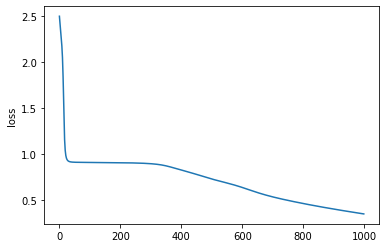

In [11]:
loss , y_pred = nn.train(epochs=1000 ,lr=0.1,verbose=False)

### Prediction for the test data

In [12]:
y_pred = nn.predict( x_test )
nn.accuracy(y_pred,y_test)


train accuracy =  84.59 %
